# With Chat Time vs Without Chat Time

## Overview

compare.ipynb compares the each ML models' performance trained on two different preprocessing approaches:
1. **With Chat Time**: Includes the `chatTime` column in the preprocessed dataset
2. **Without Chat Time**: Excludes the `chatTime` column



## 0) Set Paths


In [7]:
WITH_CHAT_TIME_PATH = "../with_chat_time/analysis_outputs/reports/model_comparison.csv"
WITHOUT_CHAT_TIME_PATH = "../without_chat_time/analysis_outputs/reports/model_comparison.csv"

OUTPUT_DIR = "analysis"
REPORTS_DIR = f"{OUTPUT_DIR}/reports"
PLOTS_DIR = f"{OUTPUT_DIR}/plots"

import os
for d in [OUTPUT_DIR, REPORTS_DIR, PLOTS_DIR]:
    os.makedirs(d, exist_ok=True)
    
print(f"Output directory: {OUTPUT_DIR}")
print(f"Reports will be saved to: {REPORTS_DIR}")
print(f"Plots will be saved to: {PLOTS_DIR}")


Output directory: analysis
Reports will be saved to: analysis/reports
Plots will be saved to: analysis/plots


## 1) Import Libraries


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
        
sns.set_palette("husl")

# Set figure size defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11


## 2) Load Model Comparison Data


In [9]:
# Load data from both approaches
df_with = pd.read_csv(WITH_CHAT_TIME_PATH)
df_without = pd.read_csv(WITHOUT_CHAT_TIME_PATH)

df_with['Approach'] = 'With Chat Time'
df_without['Approach'] = 'Without Chat Time'

df_combined = pd.concat([df_with, df_without], ignore_index=True)

print("\n")
print("WITH CHAT TIME RESULTS:")
print("\n")
print(df_with.to_string(index=False))
print("\n")
print("WITHOUT CHAT TIME RESULTS:")
print("\n")
print(df_without.to_string(index=False))




WITH CHAT TIME RESULTS:


                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC       Approach
Multinomial Naive Bayes  0.927921   0.931500 0.927921  0.921976 0.956620 With Chat Time
    Logistic Regression  0.936095   0.938035 0.936095  0.931906 0.971166 With Chat Time
   LDA-based Classifier  0.803455   0.734305 0.803455  0.730214 0.655684 With Chat Time


WITHOUT CHAT TIME RESULTS:


                  Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC          Approach
Multinomial Naive Bayes  0.928850   0.931972 0.928850  0.923210 0.947832 Without Chat Time
    Logistic Regression  0.934795   0.936748 0.934795  0.930432 0.966261 Without Chat Time
   LDA-based Classifier  0.806056   0.649726 0.806056  0.719498 0.618652 Without Chat Time


## 3) Calculate Performance Differences


In [10]:

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

# Merge dataframes and calculate performance differences
df_diff = df_with.merge(df_without, on='Model', suffixes=('_with', '_without'))
df_diff_results = pd.DataFrame({'Model': df_diff['Model']})

# Calculate performance differences for each metric
for metric in metrics:
    col_with = f'{metric}_with'
    col_without = f'{metric}_without'
    df_diff_results[f'{metric}_With'] = df_diff[col_with]
    df_diff_results[f'{metric}_Without'] = df_diff[col_without]
    df_diff_results[f'{metric}_Diff'] = df_diff[col_with] - df_diff[col_without]
    df_diff_results[f'{metric}_Diff_Pct'] = ((df_diff[col_with] - df_diff[col_without]) / df_diff[col_without]) * 100

print("PERFORMANCE DIFFERENCES (With Chat Time - Without Chat Time):")
print("Positive values indicate 'With Chat Time' performs better")
print("Negative values indicate 'Without Chat Time' performs better\n")

# Display and save results
print(df_diff_results[['Model'] + [f'{m}_Diff' for m in metrics] + [f'{m}_Diff_Pct' for m in metrics]].to_string(index=False))
df_diff_results.to_csv(f"{REPORTS_DIR}/performance_differences.csv", index=False)


PERFORMANCE DIFFERENCES (With Chat Time - Without Chat Time):
Positive values indicate 'With Chat Time' performs better
Negative values indicate 'Without Chat Time' performs better

                  Model  Accuracy_Diff  Precision_Diff  Recall_Diff  F1-Score_Diff  ROC-AUC_Diff  Accuracy_Diff_Pct  Precision_Diff_Pct  Recall_Diff_Pct  F1-Score_Diff_Pct  ROC-AUC_Diff_Pct
Multinomial Naive Bayes      -0.000929       -0.000473    -0.000929      -0.001234      0.008788          -0.100000           -0.050705        -0.100000          -0.133644          0.927148
    Logistic Regression       0.001300        0.001287     0.001300       0.001474      0.004905           0.139110            0.137352         0.139110           0.158435          0.507644
   LDA-based Classifier      -0.002601        0.084579    -0.002601       0.010716      0.037032          -0.322655           13.017629        -0.322655           1.489416          5.985976


## 4) Bar Chart: All Metrics Comparison


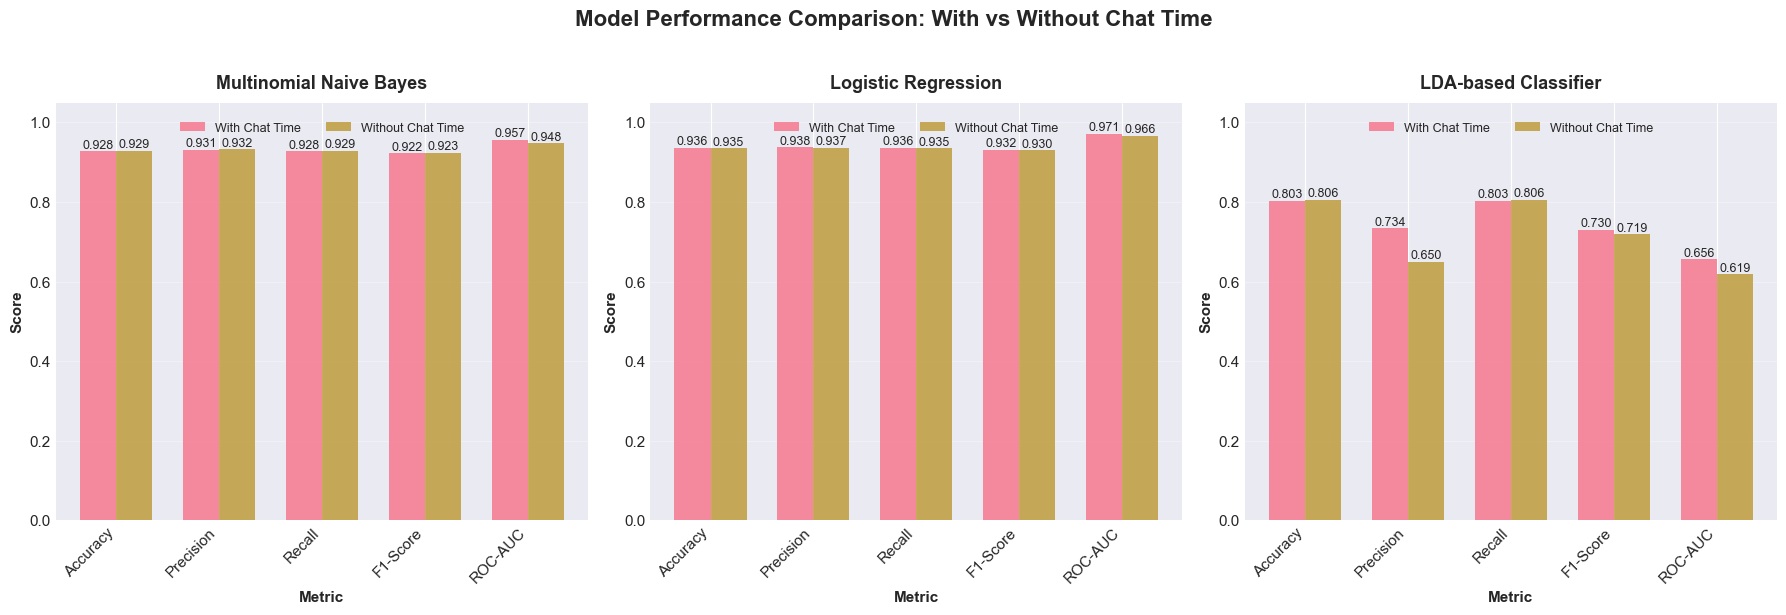

In [11]:
plot_data = df_combined.melt(
    id_vars=['Model', 'Approach'],
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
models = df_combined['Model'].unique()

for idx, model in enumerate(models):
    model_data = plot_data[plot_data['Model'] == model]
    
    # Create combined bar chart
    ax = axes[idx]
    x = np.arange(len(metrics))
    width = 0.35
    
    with_scores = [model_data[(model_data['Approach'] == 'With Chat Time') & 
                              (model_data['Metric'] == m)]['Score'].values[0] 
                   for m in metrics]
    without_scores = [model_data[(model_data['Approach'] == 'Without Chat Time') & 
                                (model_data['Metric'] == m)]['Score'].values[0] 
                     for m in metrics]
    
    bars1 = ax.bar(x - width/2, with_scores, width, label='With Chat Time', alpha=0.8)
    bars2 = ax.bar(x + width/2, without_scores, width, label='Without Chat Time', alpha=0.8)
    
    ax.set_xlabel('Metric', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax.set_title(f'{model}', fontsize=13, fontweight='bold', pad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_ylim([0, 1.05])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.98), ncol=2, fontsize=9, framealpha=0.9)
    ax.grid(axis='y', alpha=0.3)
    

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison: With vs Without Chat Time', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/metrics_comparison_all_models.png", dpi=300, bbox_inches='tight')
plt.show()


## 5) Summary Report Generation


In [12]:
# Find best model for each approach
best_with = df_with.loc[df_with['Accuracy'].idxmax()]
best_without = df_without.loc[df_without['Accuracy'].idxmax()]

# Calculate overall winner
overall_winner_acc_with = df_with['Accuracy'].max()
overall_winner_acc_without = df_without['Accuracy'].max()

# Generate report
report_lines = [
    "FEATURE COMPARISON REPORT (WITH CHAT TIME vs WITHOUT CHAT TIME): \n",
    f"  • Best Model (With Chat Time):    {best_with['Model']} - Accuracy: {best_with['Accuracy']:.4f}",
    f"  • Best Model (Without Chat Time): {best_without['Model']} - Accuracy: {best_without['Accuracy']:.4f}",
    f"  • Overall Winner: {'WITH Chat Time' if overall_winner_acc_with > overall_winner_acc_without else 'WITHOUT Chat Time'}",
    "",
]



# Write and save report to file
report_text = "\n".join(report_lines)
with open(f"{REPORTS_DIR}/comparison_summary_report.txt", 'w') as f:
    f.write(report_text)

print(report_text)


FEATURE COMPARISON REPORT (WITH CHAT TIME vs WITHOUT CHAT TIME): 

  • Best Model (With Chat Time):    Logistic Regression - Accuracy: 0.9361
  • Best Model (Without Chat Time): Logistic Regression - Accuracy: 0.9348
  • Overall Winner: WITH Chat Time

